# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
seed = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
tf.__version__

'2.7.0'

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


If you do not have a GPU, uncomment and run the next commands.

In [6]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [7]:
from google.colab import drive
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.util import random_noise
from scipy import ndimage
from sklearn.utils import shuffle
import gc
from sklearn import metrics

In [8]:
%matplotlib inline

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [11]:
from efficientnet_lite import EfficientNetLiteB0

# 2. Utility Functions

You can use this function to load your training data.

In [12]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [13]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [14]:
def plot_images(images, labels, index):
  
  fig, axs = plt.subplots(2, 5, figsize=(20, 8))

  axs[0, 0].imshow(images[(index*10)+0])
  axs[0, 0].set_title(class_mapping[labels[(index*10)+0]])

  axs[0, 1].imshow(images[(index*10)+1])
  axs[0, 1].set_title(class_mapping[labels[(index*10)+1]])

  axs[0, 2].imshow(images[(index*10)+2])
  axs[0, 2].set_title(class_mapping[labels[(index*10)+2]])

  axs[0, 3].imshow(images[(index*10)+3])
  axs[0, 3].set_title(class_mapping[labels[(index*10)+3]])

  axs[0, 4].imshow(images[(index*10)+4])
  axs[0, 4].set_title(class_mapping[labels[(index*10)+4]])

  axs[1, 0].imshow(images[(index*10)+5])
  axs[1, 0].set_title(class_mapping[labels[(index*10)+5]])

  axs[1, 1].imshow(images[(index*10)+6])
  axs[1, 1].set_title(class_mapping[labels[(index*10)+6]])

  axs[1, 2].imshow(images[(index*10)+7])
  axs[1, 2].set_title(class_mapping[labels[(index*10)+7]])

  axs[1, 3].imshow(images[(index*10)+8])
  axs[1, 3].set_title(class_mapping[labels[(index*10)+8]])

  axs[1, 4].imshow(images[(index*10)+9])
  axs[1, 4].set_title(class_mapping[labels[(index*10)+9]])

In [15]:
def plot_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))  

In [16]:
def plot_val_images_and_predictions(val_images, val_labels, val_predictions):
  
  fig, axs = plt.subplots(4, 4, figsize=(16, 16))

  axs[0, 0].imshow(val_images[0])
  axs[0, 0].set_title(class_mapping[val_labels[0]]+'; '+class_mapping[predictions[0]])

  axs[0, 1].imshow(val_images[1])
  axs[0, 1].set_title(class_mapping[val_labels[1]]+'; '+class_mapping[predictions[1]])

  axs[0, 2].imshow(val_images[2])
  axs[0, 2].set_title(class_mapping[val_labels[2]]+'; '+class_mapping[predictions[2]])

  axs[0, 3].imshow(val_images[3])
  axs[0, 3].set_title(class_mapping[val_labels[3]]+'; '+class_mapping[predictions[3]])

  axs[1, 0].imshow(val_images[4])
  axs[1, 0].set_title(class_mapping[val_labels[4]]+'; '+class_mapping[predictions[4]])

  axs[1, 1].imshow(val_images[5])
  axs[1, 1].set_title(class_mapping[val_labels[5]]+'; '+class_mapping[predictions[5]])

  axs[1, 2].imshow(val_images[6])
  axs[1, 2].set_title(class_mapping[val_labels[6]]+'; '+class_mapping[predictions[6]])

  axs[1, 3].imshow(val_images[7])
  axs[1, 3].set_title(class_mapping[val_labels[7]]+'; '+class_mapping[predictions[7]])

  axs[2, 0].imshow(val_images[8])
  axs[2, 0].set_title(class_mapping[val_labels[8]]+'; '+class_mapping[predictions[8]])

  axs[2, 1].imshow(val_images[9])
  axs[2, 1].set_title(class_mapping[val_labels[9]]+'; '+class_mapping[predictions[9]])

  axs[2, 2].imshow(val_images[10])
  axs[2, 2].set_title(class_mapping[val_labels[10]]+'; '+class_mapping[predictions[10]])

  axs[2, 3].imshow(val_images[11])
  axs[2, 3].set_title(class_mapping[val_labels[11]]+'; '+class_mapping[predictions[11]])

  axs[3, 0].imshow(val_images[12])
  axs[3, 0].set_title(class_mapping[val_labels[12]]+'; '+class_mapping[predictions[12]])

  axs[3, 1].imshow(val_images[13])
  axs[3, 1].set_title(class_mapping[val_labels[13]]+'; '+class_mapping[predictions[13]])

  axs[3, 2].imshow(val_images[14])
  axs[3, 2].set_title(class_mapping[val_labels[14]]+'; '+class_mapping[predictions[14]])

  axs[3, 3].imshow(val_images[15])
  axs[3, 3].set_title(class_mapping[val_labels[15]]+'; '+class_mapping[predictions[15]])

In [17]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [18]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [19]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [20]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [21]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [22]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [23]:
y_train.shape

TensorShape([80])

In [24]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

In [25]:
x_train = x_train.numpy().astype('uint8')
y_train = y_train.numpy()

### Explore images

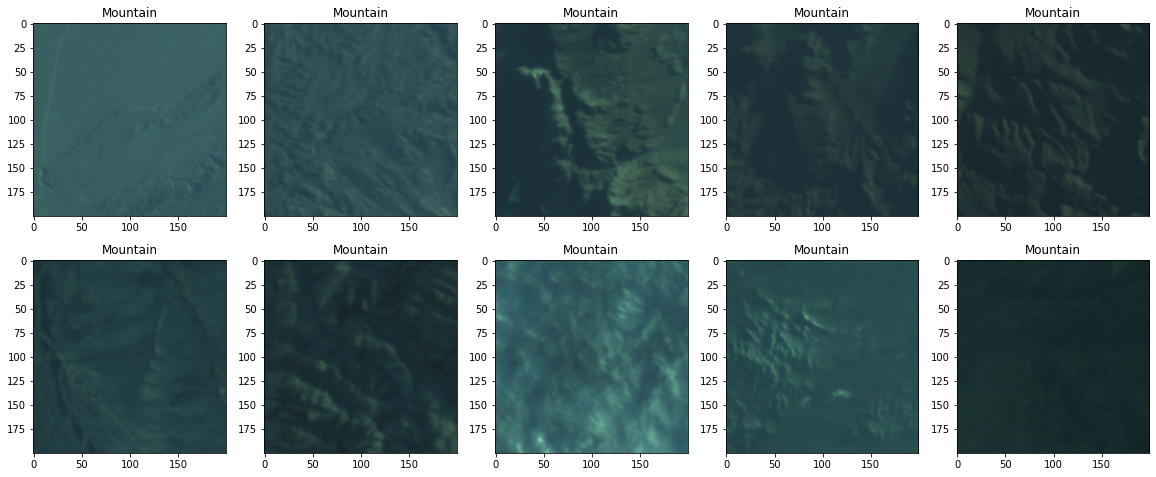

In [26]:
plot_images(x_train, y_train, 2)

### Train val split

In [27]:
step = 10
val_indices = [3,
               4,
               4 + step,
               5 + step,
               3 + 2 * step,
               6 + 2 * step,
               7 + 3 * step,
               8 + 3 * step,
               2 + 4 * step,
               7 + 4 * step,
               2 + 5 * step,
               3 + 5 * step,
               3 + 6 * step,
               5 + 6 * step,
               6 + 7 * step,
               7 + 7 * step]
val_indices

[3, 4, 14, 15, 23, 26, 37, 38, 42, 47, 52, 53, 63, 65, 76, 77]

In [28]:
x_val = x_train[val_indices, :]
y_val = y_train[val_indices]
print(x_val.shape, y_val.shape)

(16, 200, 200, 3) (16,)


In [29]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

Class: 0; Occurrences: 2
Class: 1; Occurrences: 2
Class: 2; Occurrences: 2
Class: 3; Occurrences: 2
Class: 4; Occurrences: 2
Class: 5; Occurrences: 2
Class: 6; Occurrences: 2
Class: 7; Occurrences: 2


In [30]:
x_train = np.delete(x_train, val_indices, axis=0)
y_train = np.delete(y_train, val_indices, axis=0)
print(x_train.shape, y_train.shape)

(64, 200, 200, 3) (64,)


In [31]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

Class: 0; Occurrences: 8
Class: 1; Occurrences: 8
Class: 2; Occurrences: 8
Class: 3; Occurrences: 8
Class: 4; Occurrences: 8
Class: 5; Occurrences: 8
Class: 6; Occurrences: 8
Class: 7; Occurrences: 8


### Augment train images

#### Try out different augmentations

In [32]:
image_to_plot = 19

Class: Mountain


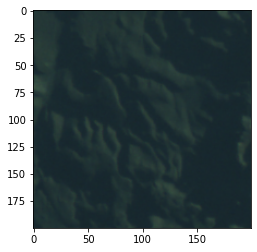

In [33]:
plot_image(x_train, y_train, image_to_plot)

#### Flip left right

22 88


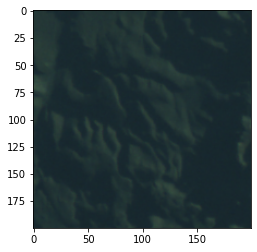

In [34]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_left_right_example = tf.image.stateless_random_flip_left_right(x_train[image_to_plot], augmentation_seed).numpy().astype('uint8')
print(flip_left_right_example.min(), flip_left_right_example.max())
plt.imshow(flip_left_right_example)
plt.show()

#### Flip up down

22 88


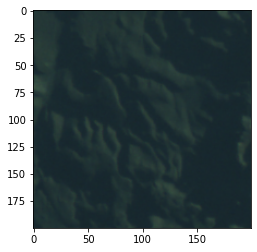

In [35]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_up_down_example = tf.image.stateless_random_flip_up_down(x_train[image_to_plot], augmentation_seed).numpy().astype('uint8')
print(flip_up_down_example.min(), flip_up_down_example.max())
plt.imshow(flip_up_down_example)
plt.show()

#### Rotate 90 degrees

22 88


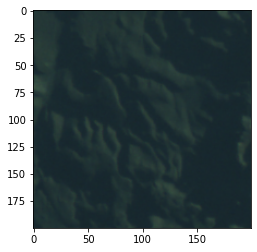

In [36]:
k = random.choice([0, 1, 2, 3])
rot90_example = tf.image.rot90(x_train[image_to_plot], k=k).numpy().astype('uint8')
print(rot90_example.min(), rot90_example.max())
plt.imshow(rot90_example)
plt.show()

#### Crop

22 74


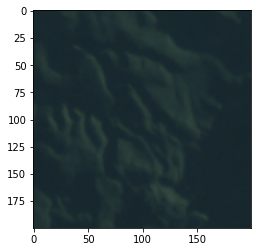

In [37]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
heigth = 200
width = 200
factor = random.choice(np.arange(0.8, 1.05, 0.05))
random_crop_example = tf.image.stateless_random_crop(x_train[image_to_plot], [int(heigth*factor), int(width*factor), 3], augmentation_seed)
random_crop_example = tf.image.resize(random_crop_example, [heigth, width]).numpy().astype('uint8')
print(random_crop_example.min(), random_crop_example.max())
plt.imshow(random_crop_example)
plt.show()

#### Brightness

12 78


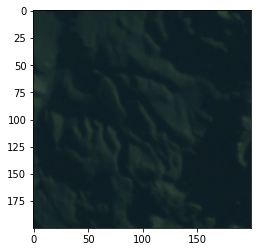

In [38]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
brightness_example = (tf.image.stateless_random_brightness(x_train[image_to_plot]/255, 0.2, augmentation_seed)*255).numpy().astype('uint8')
print(brightness_example.min(), brightness_example.max())
plt.imshow(brightness_example)
plt.show()

#### Hue

22 88


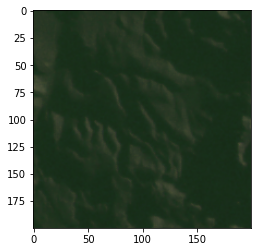

In [39]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
hue_example = tf.image.stateless_random_hue(x_train[image_to_plot], 0.3, augmentation_seed).numpy().astype('uint8')
print(hue_example.min(), hue_example.max())
plt.imshow(hue_example)
plt.show()

#### Contrast

21 89


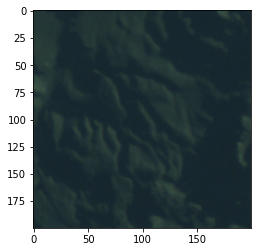

In [40]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
contrast_example = tf.image.stateless_random_contrast(x_train[image_to_plot], 0.6, 1.4, augmentation_seed).numpy().astype('uint8')
print(contrast_example.min(), contrast_example.max())
plt.imshow(contrast_example)
plt.show()

#### Saturation

28 88


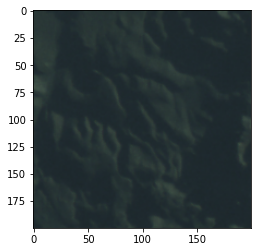

In [41]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
saturation_example = tf.image.stateless_random_saturation(x_train[image_to_plot], 0.6, 1.4, augmentation_seed).numpy().astype('uint8')
print(saturation_example.min(), saturation_example.max())
plt.imshow(saturation_example)
plt.show()

#### Gaussian noise

0 99


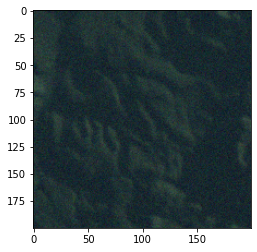

In [42]:
gaussian_noise_example = (random_noise(x_train[image_to_plot]/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255).astype('uint8')
print(gaussian_noise_example.min(), gaussian_noise_example.max())
plt.imshow(gaussian_noise_example)
plt.show()

#### Salt and pepper noise

0 255


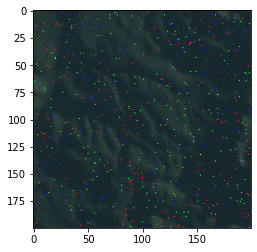

In [43]:
salt_and_pepper_noise_example = (random_noise(x_train[image_to_plot]/255, mode='s&p', amount=0.01, seed=seed)*255).astype('uint8')
print(salt_and_pepper_noise_example.min(), salt_and_pepper_noise_example.max())
plt.imshow(salt_and_pepper_noise_example)
plt.show()

#### Median filter

23 69


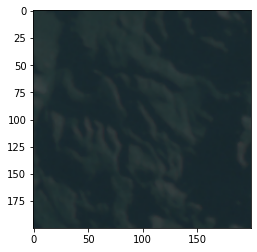

In [44]:
median_filter_example = ndimage.median_filter(x_train[image_to_plot], size=3, mode='nearest').astype('uint8')
print(median_filter_example.min(), median_filter_example.max())
plt.imshow(median_filter_example)
plt.show()

### Manual augmentations

In [45]:
manual_augmentations = False
gaussian_noise = False
salt_and_pepper_noise = False

if manual_augmentations:

  x_train_rot90_ccw = np.rot90(x_train, axes=(1,2))
  x_train_augmented = np.vstack([x_train, x_train_rot90_ccw])
  y_train_augmented = np.concatenate([y_train, y_train])

  x_train_rot180 = np.rot90(np.rot90(x_train, axes=(1,2)), axes=(1,2))
  x_train_augmented = np.vstack([x_train_augmented, x_train_rot180])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])

  x_train_rot90_cw = np.rot90(x_train, axes=(2,1))
  x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])

  x_train_flipud = np.array([np.flipud(i) for i in x_train])
  x_train_augmented = np.vstack([x_train_augmented, x_train_flipud])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])

  x_train_fliplr = np.array([np.fliplr(i) for i in x_train])
  x_train_augmented = np.vstack([x_train_augmented, x_train_fliplr])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])

  x_train_rot90_ccw_flipud = np.array([np.flipud(i) for i in x_train_rot90_ccw])
  x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_ccw_flipud])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])

  x_train_rot90_cw_flipud = np.array([np.flipud(i) for i in x_train_rot90_cw])
  x_train_augmented = np.vstack([x_train_augmented, x_train_rot90_cw_flipud])
  y_train_augmented = np.concatenate([y_train_augmented, y_train])  

  if gaussian_noise or salt_and_pepper_noise:
    
    x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented, random_state=seed)

    factor = 0.1
    share = 0.5
    max_index = int(round(x_train_augmented.shape[0] * share, 0))

  if gaussian_noise:

    x_train_noise = np.array([np.round(image + (np.random.normal(image, factor * image)), 0) for image in x_train_augmented[:max_index]]).astype('uint8')
    x_train_augmented = np.vstack([x_train_augmented, x_train_noise])
    y_train_augmented = np.concatenate([y_train_augmented, y_train_augmented[:max_index]])
  
  if salt_and_pepper_noise:

    x_train_noise = np.array([random_noise(image/255, mode='s&p', amount=0.01, seed=seed)*255 for image in x_train_augmented[:max_index]]).astype('uint8')
    x_train_augmented = np.vstack([x_train_augmented, x_train_noise])
    y_train_augmented = np.concatenate([y_train_augmented, y_train_augmented[:max_index]])
  
  print(x_train_augmented.shape, y_train_augmented.shape)

#### Apply augmentations to all train images n times using TensorFlow

Augmentation block 1: flip and rotate

In [46]:
%%time

num_augmentations = 20

if num_augmentations == 0:
  pass

else:

  x_train_augmented = np.copy(x_train)
  augmentations = np.copy(x_train)

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    # flip left right
    augmentations = tf.image.stateless_random_flip_left_right(augmentations, augmentation_seed).numpy().astype('uint8')

    # flip up down
    augmentations = tf.image.stateless_random_flip_up_down(augmentations, augmentation_seed).numpy().astype('uint8')

    # rotate 90 degrees
    k = random.choice([0, 1, 2, 3])
    augmentations = np.array([tf.image.rot90(image, k=k) for image in augmentations]).astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

  augmentation_base = x_train_augmented.shape[0]

[18854 11114]
[ 8657 62798]
[30893 33932]
[22261  5949]
[ 8032 57878]
[34503 10147]
[30069 63841]
[56831 12862]
[24431 64371]
[51024 50923]
[48374 54585]
[47582 20607]
[35083 57280]
[40000 58694]
[48333 15873]
[58152 38877]
[54978 40134]
[54585 35948]
[40176 44443]
[27072 28638]
(1344, 200, 200, 3) (1344,)
(255, 200, 200, 3) (255,)
CPU times: user 18.9 s, sys: 442 ms, total: 19.3 s
Wall time: 23 s


Augmentation block 2: brigthness, hue, contrast and saturation

In [47]:
%%time

brigthness = False

if brigthness:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = (tf.image.stateless_random_brightness(augmentations/255, 0.2, augmentation_seed)*255).numpy().astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [48]:
%%time

hue = False

if hue:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = tf.image.stateless_random_hue(augmentations, 0.3, augmentation_seed).numpy().astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [49]:
%%time

contrast = False

if contrast:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = tf.image.stateless_random_contrast(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 6.2 µs


In [50]:
%%time

saturation = False

if saturation:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = tf.image.stateless_random_saturation(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


Augmentation block 3: crop and noise

In [51]:
%%time

crop = False

if crop:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    factor = random.choice(np.arange(0.8, 1.05, 0.05))
    random_crop = np.array([tf.image.stateless_random_crop(image, [int(heigth*factor), int(width*factor), 3], augmentation_seed) for image in augmentations])
    augmentations = tf.image.resize(random_crop, [heigth, width]).numpy().astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.58 µs


In [52]:
%%time

gaussian_noise = False

if gaussian_noise:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = np.array([random_noise(image/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255 for image in augmentations]).astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [53]:
%%time

salt_and_pepper_noise = False

if salt_and_pepper_noise:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  num_augmentations = 3

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
    print(augmentation_seed)

    augmentations = np.array([random_noise(image/255, mode='s&p', amount=0.01, seed=seed)*255 for image in augmentations]).astype('uint8')

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented] * (num_augmentations + 1))

  # remove duplicate augmentations
  print(x_train_augmented.shape, y_train_augmented.shape)
  x_train_augmented, indices = np.unique(x_train_augmented, axis=0, return_index=True)
  y_train_augmented = y_train_augmented[indices]
  print(x_train_augmented.shape, y_train_augmented.shape)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [54]:
%%time

median_filter = True

if median_filter:

  augmentations = np.copy(x_train_augmented[:augmentation_base])

  augmentations = np.array([ndimage.median_filter(image, size=3, mode='nearest') for image in augmentations]).astype('uint8')

  x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train_augmented, y_train_augmented[:augmentation_base]])

  print(x_train_augmented.shape, y_train_augmented.shape)

(510, 200, 200, 3) (510,)
CPU times: user 10.6 s, sys: 29.6 ms, total: 10.6 s
Wall time: 10.6 s


#### Check augmentations

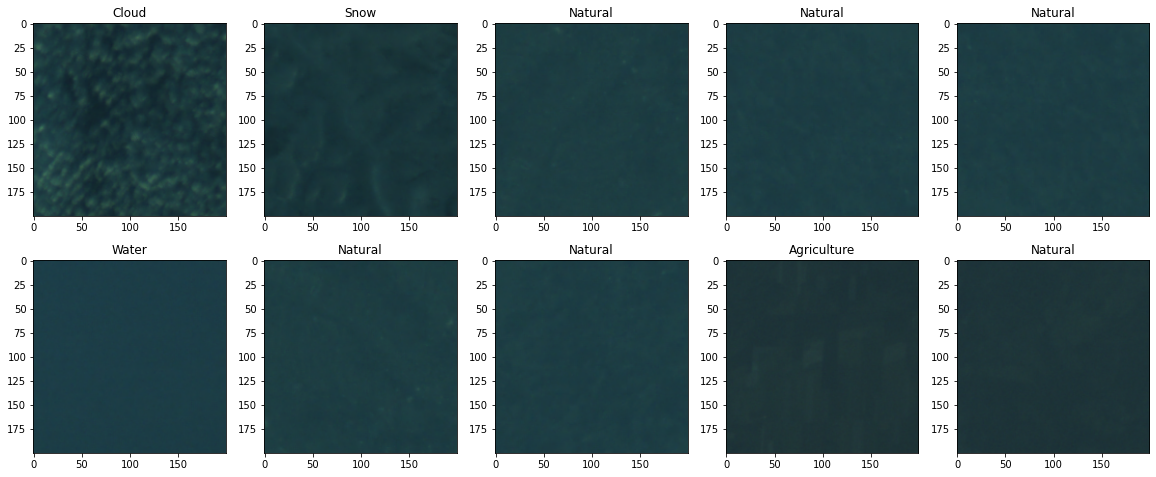

In [55]:
plot_images(x_train_augmented, y_train_augmented, 10)

### Shuffle and convert images and labels

In [56]:
if num_augmentations == 0:
  x_train, y_train = shuffle(x_train, y_train, random_state=seed)
  x_train = tf.convert_to_tensor(x_train)
  y_train = tf.convert_to_tensor(y_train, dtype=np.int32)

else:
  x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented, random_state=seed)
  x_train = tf.convert_to_tensor(x_train_augmented)
  y_train = tf.convert_to_tensor(y_train_augmented, dtype=np.int32)

  del x_train_augmented, y_train_augmented
  gc.collect()

x_val, y_val = shuffle(x_val, y_val, random_state=seed)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val, dtype=np.int32)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(510, 200, 200, 3) (510,) (16, 200, 200, 3) (16,)


# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [58]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True)

In [59]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=55, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val, y_val))

Epoch 1/55
64/64 [==============================] - 12s 76ms/step - loss: 4.4669 - sparse_categorical_accuracy: 0.1824 - val_loss: 10.5855 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/55
64/64 [==============================] - 3s 53ms/step - loss: 3.4805 - sparse_categorical_accuracy: 0.1843 - val_loss: 3.9253 - val_sparse_categorical_accuracy: 0.1250
Epoch 3/55
64/64 [==============================] - 3s 53ms/step - loss: 3.1002 - sparse_categorical_accuracy: 0.1941 - val_loss: 4.6627 - val_sparse_categorical_accuracy: 0.1250
Epoch 4/55
64/64 [==============================] - 3s 55ms/step - loss: 2.7209 - sparse_categorical_accuracy: 0.2765 - val_loss: 4.5441 - val_sparse_categorical_accuracy: 0.1875
Epoch 5/55
64/64 [==============================] - 3s 54ms/step - loss: 2.5423 - sparse_categorical_accuracy: 0.2784 - val_loss: 3.2376 - val_sparse_categorical_accuracy: 0.1875
Epoch 6/55
64/64 [==============================] - 4s 55ms/step - loss: 2.4199 - sparse_categorical_ac

### Plot loss and accuracy

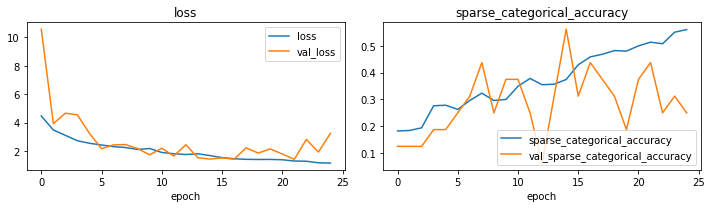

In [60]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

In [61]:
print('min val loss: {}'.format(round(min(history.history['val_loss']), 3)))

min val loss: 1.413


Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [62]:
%%time
predictions = evaluate_model(x_train, y_train)

Score: 0.6007172743574417
CPU times: user 22.9 s, sys: 851 ms, total: 23.7 s
Wall time: 23.4 s


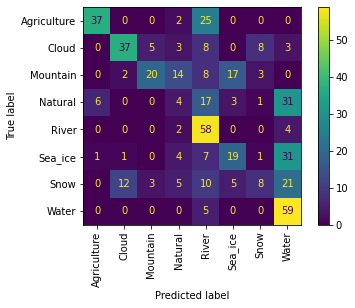

In [63]:
get_confusion_matrix(y_train, predictions)

In [64]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

Accuracy: 0.475
Precision: 0.475
Recall: 0.475
F1-Score: 0.475
              precision    recall  f1-score   support

           0       0.84      0.58      0.69        64
           1       0.71      0.58      0.64        64
           2       0.71      0.31      0.43        64
           3       0.12      0.06      0.08        62
           4       0.42      0.91      0.57        64
           5       0.43      0.30      0.35        64
           6       0.38      0.12      0.19        64
           7       0.40      0.92      0.55        64

    accuracy                           0.47       510
   macro avg       0.50      0.47      0.44       510
weighted avg       0.50      0.47      0.44       510



Class: Agriculture
Predicted: River


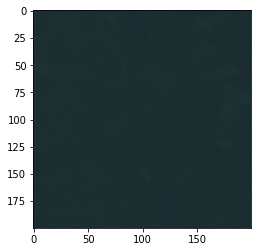

In [65]:
plot_image(x_train.numpy().astype('uint8'), y_train.numpy(), image_to_plot, pred=True, predictions=predictions)

### Evaluation on val set

In [66]:
%%time
predictions = evaluate_model(x_val, y_val)

Score: 0.5
CPU times: user 692 ms, sys: 33.1 ms, total: 725 ms
Wall time: 724 ms


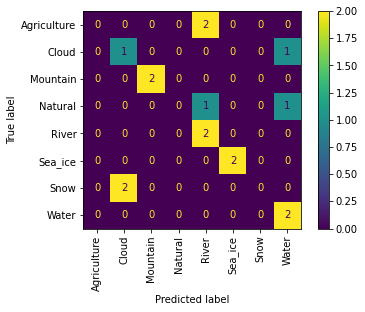

In [67]:
get_confusion_matrix(y_val, predictions)

In [68]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

Accuracy: 0.562
Precision: 0.562
Recall: 0.562
F1-Score: 0.562
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.50      0.40         2
           2       1.00      1.00      1.00         2
           3       0.00      0.00      0.00         2
           4       0.40      1.00      0.57         2
           5       1.00      1.00      1.00         2
           6       0.00      0.00      0.00         2
           7       0.50      1.00      0.67         2

    accuracy                           0.56        16
   macro avg       0.40      0.56      0.45        16
weighted avg       0.40      0.56      0.45        16



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
print('Predicted {} images out of {} correctly.'.format(int(round(metrics.accuracy_score(y_val, predictions) * x_val.shape[0], 0)), x_val.shape[0]))

Predicted 9 images out of 16 correctly.


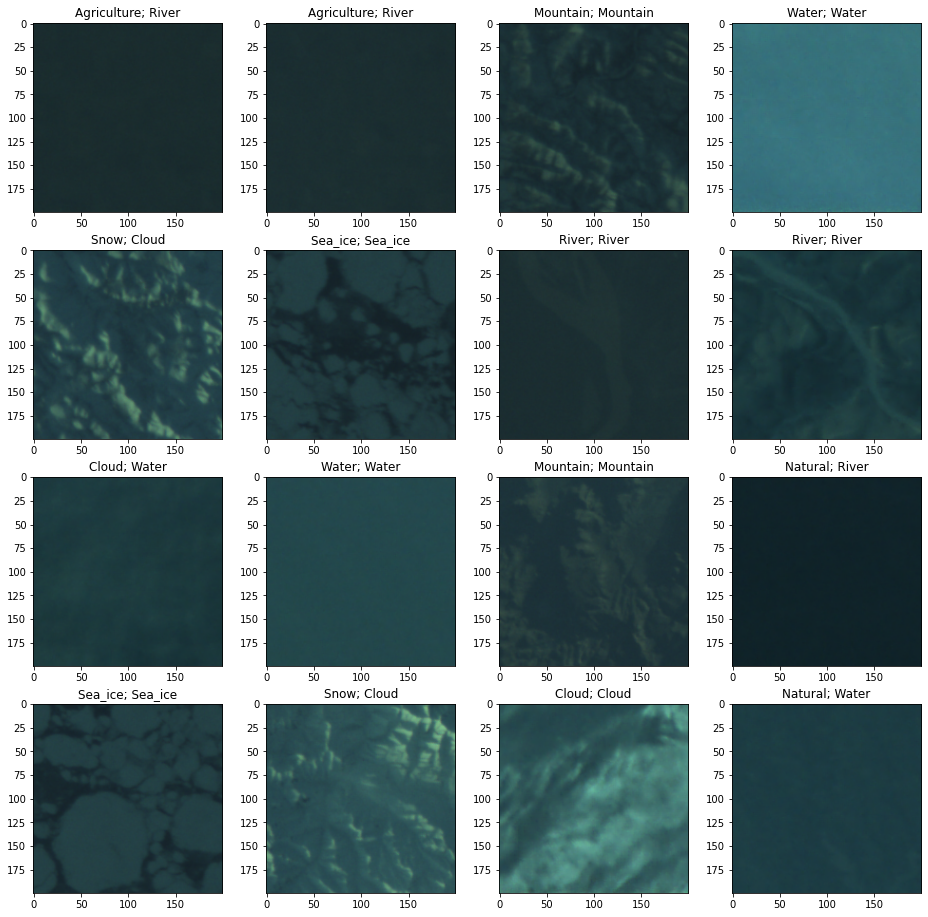

In [70]:
plot_val_images_and_predictions(x_val.numpy().astype('uint8'), y_val.numpy(), predictions)

# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [71]:
#Saving model
model.save_weights('v34.h5')

The trained model can be also loaded for further testing. 

In [72]:
#model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v34.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [73]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train, y_train)

Score: 0.6007172743574417
